In [4]:
import cv2
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import rasterio

In [8]:
mask_path = '/scratch2/ziyliu/pro_data/test_all'
img_path = mask_path
predict_path = '/scratch2/ziyliu/LAMA/lama/sate_dataset_output/test_all_predict_euler5'

In [9]:
# find all img, mask, output pairs and visualize them
mask_names = sorted(list(glob.glob(os.path.join(mask_path, '**', '*mask*.tif'), recursive=True)))
img_names = [fname.rsplit('_mask', 1)[0]+'.tif' for fname in mask_names]
#replace test_img with test_img_output
output_names = [fname.replace('pro_data/test_all', 'LAMA/lama/sate_dataset_output/test_all_predict_euler5') for fname in mask_names]

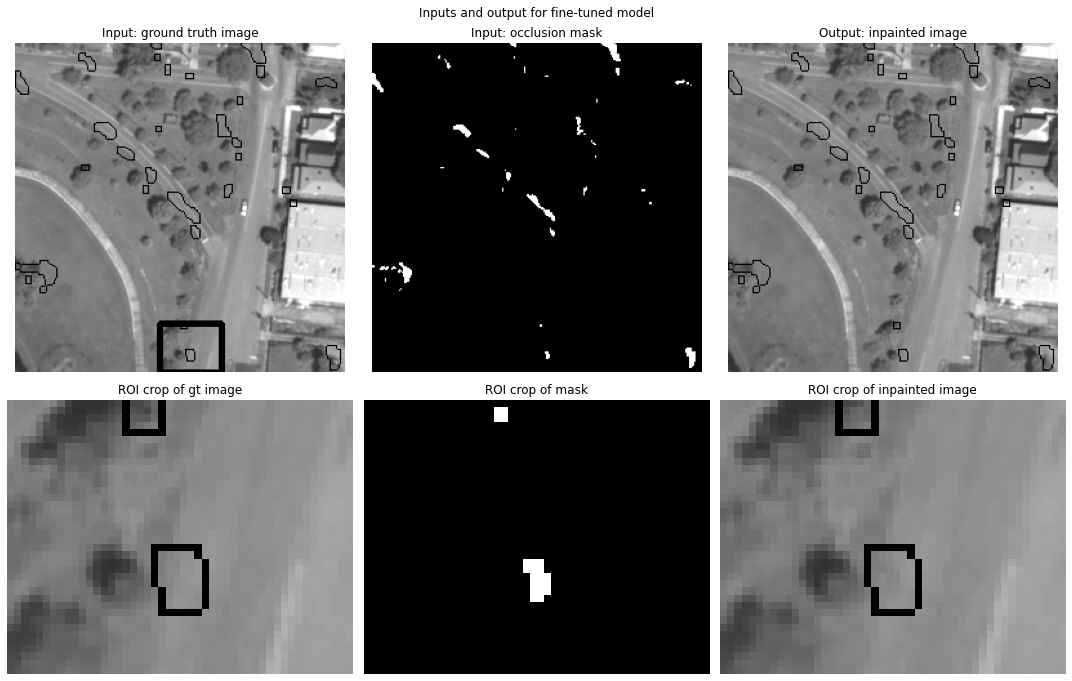

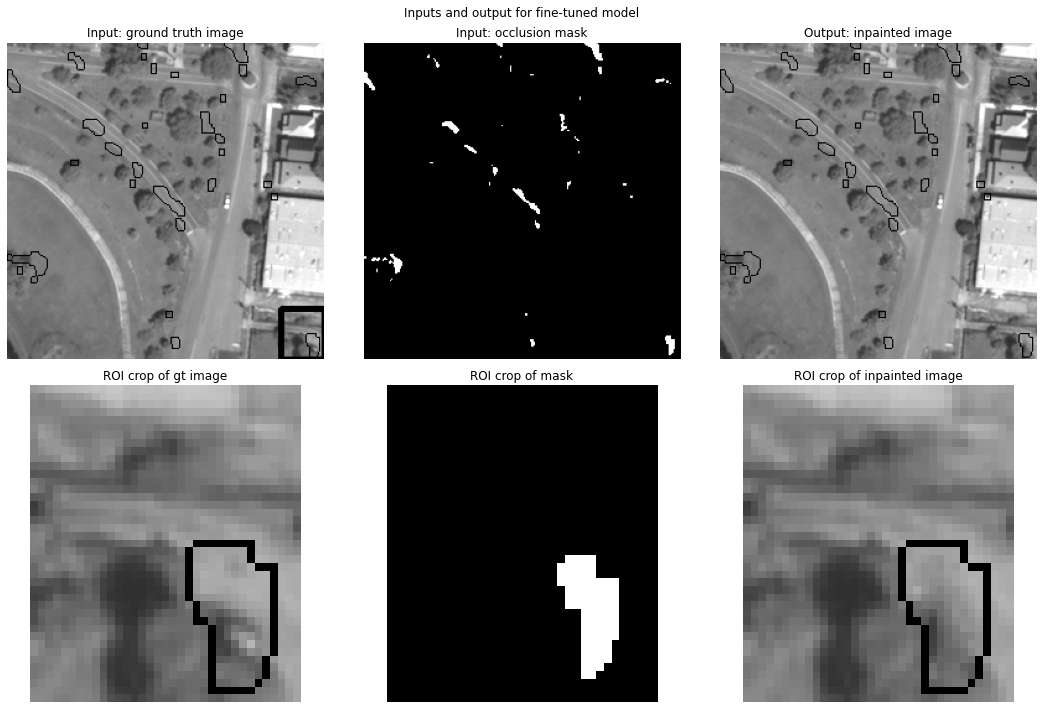

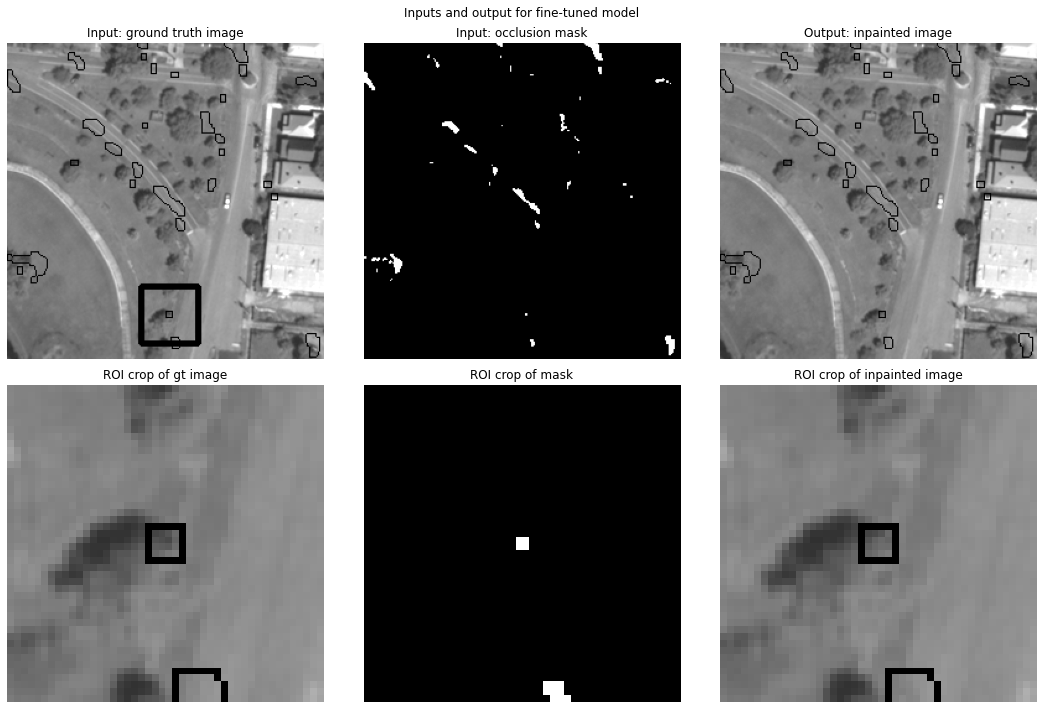

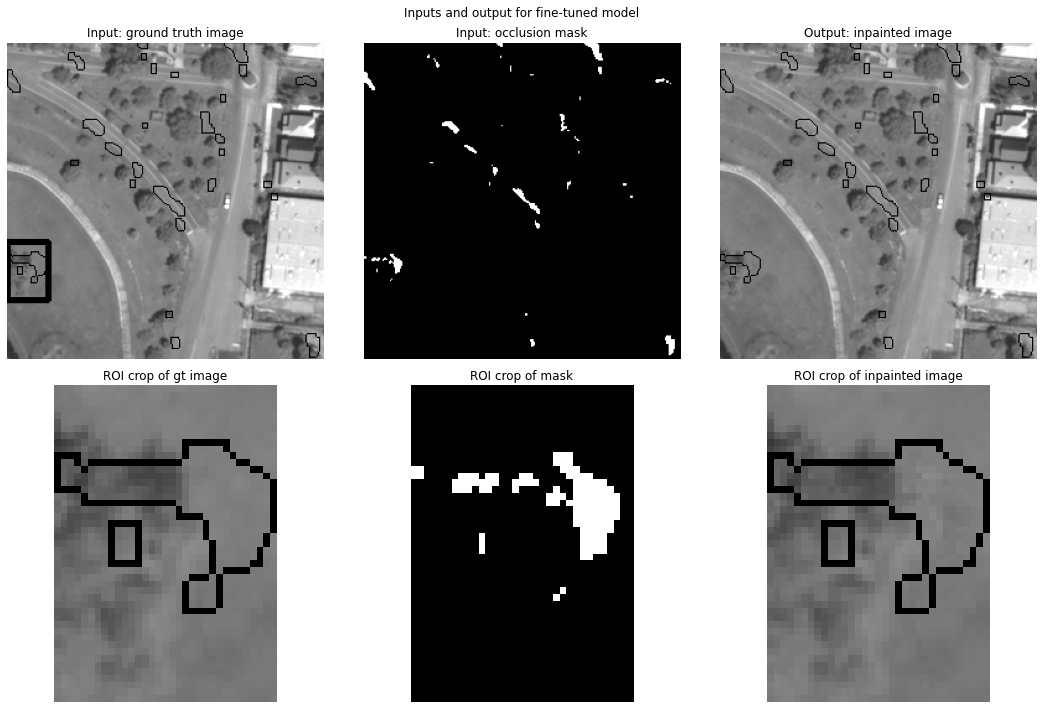

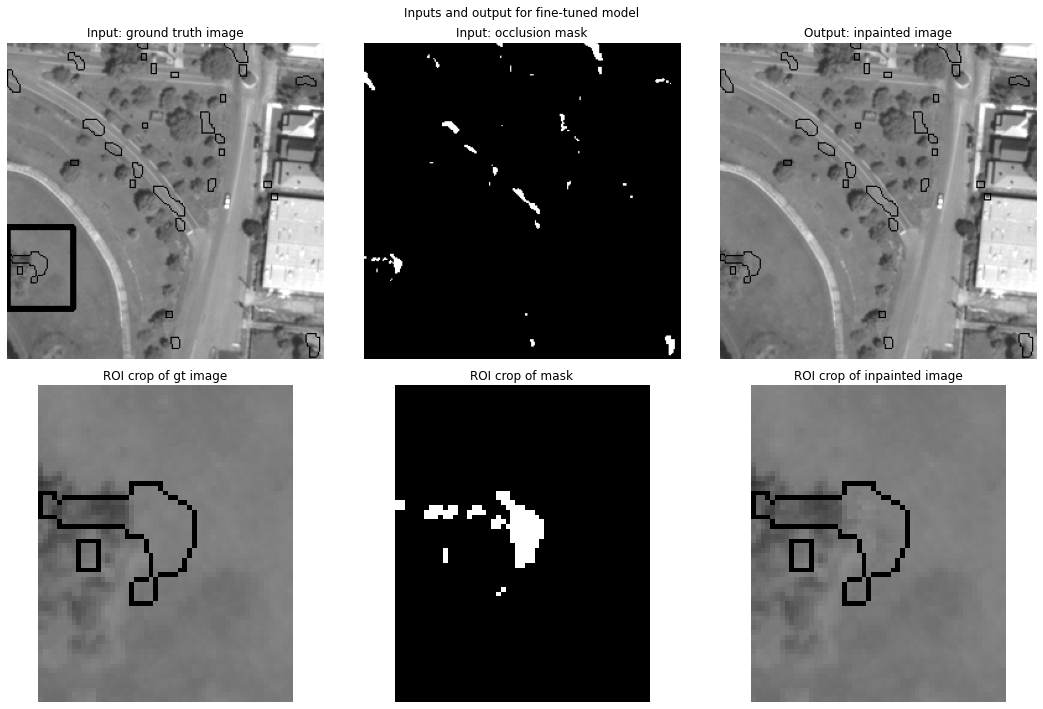

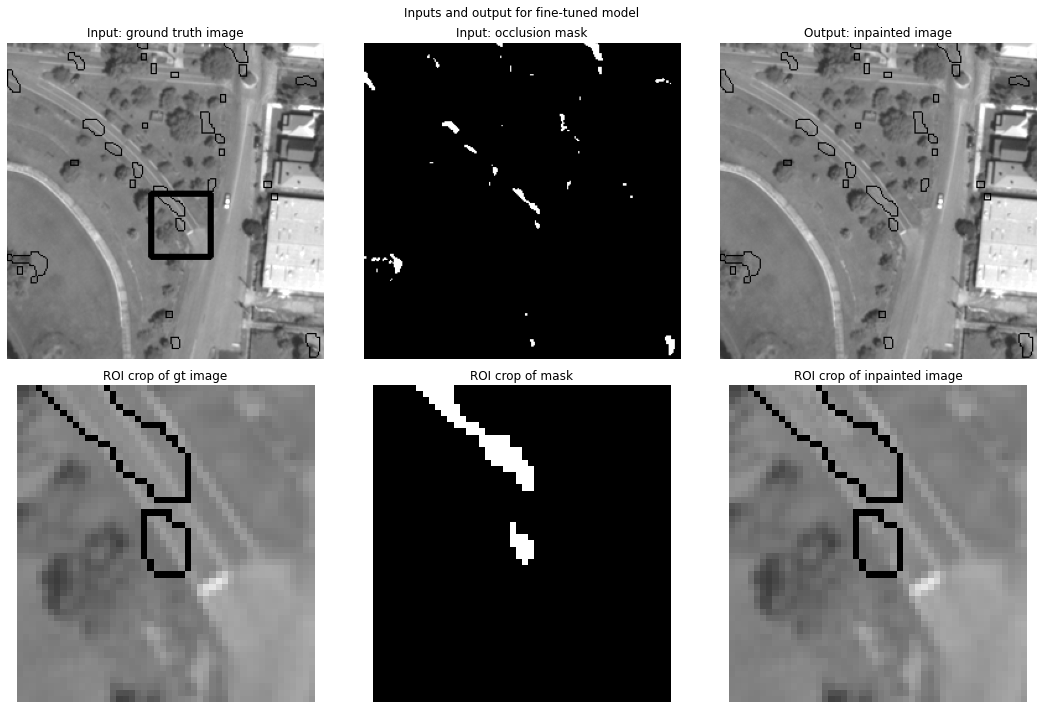

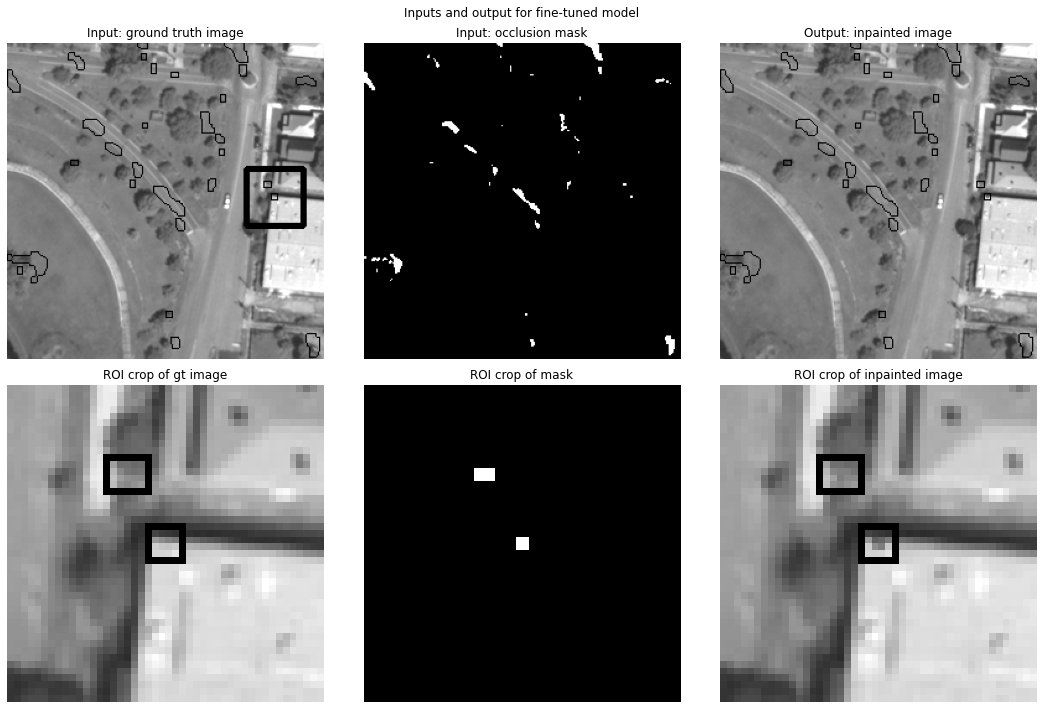

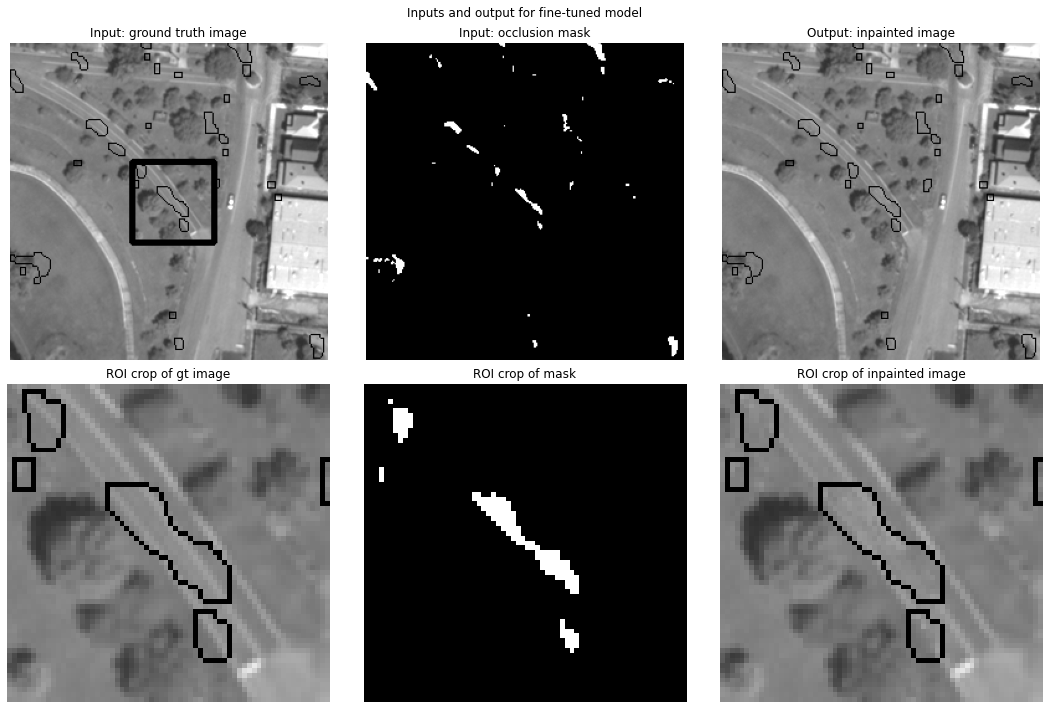

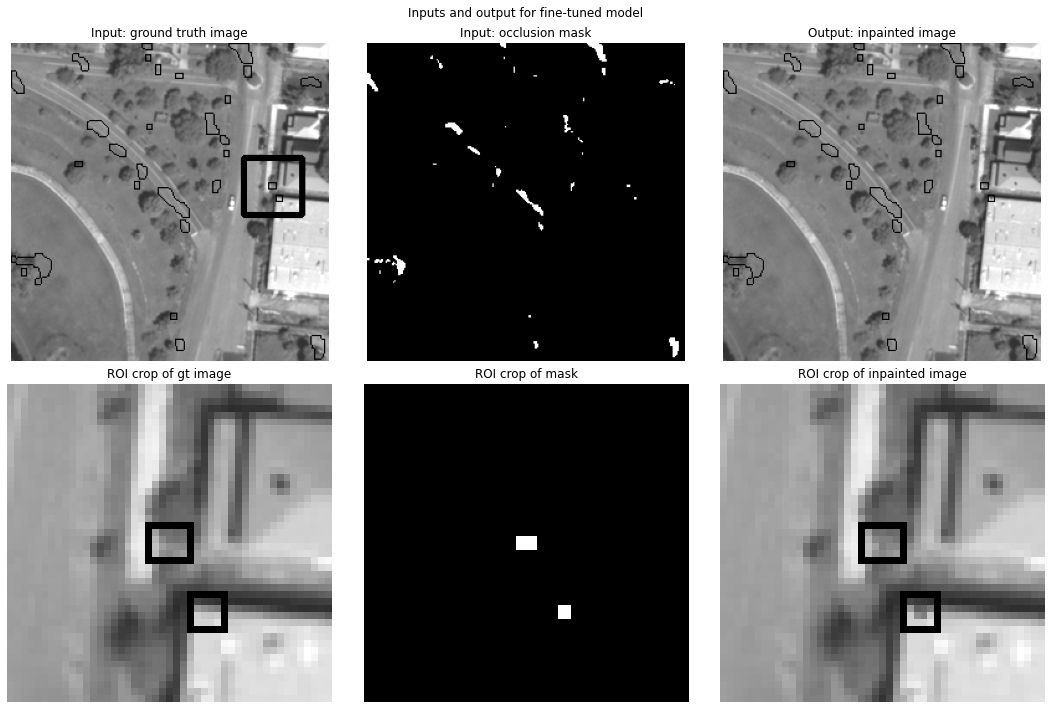

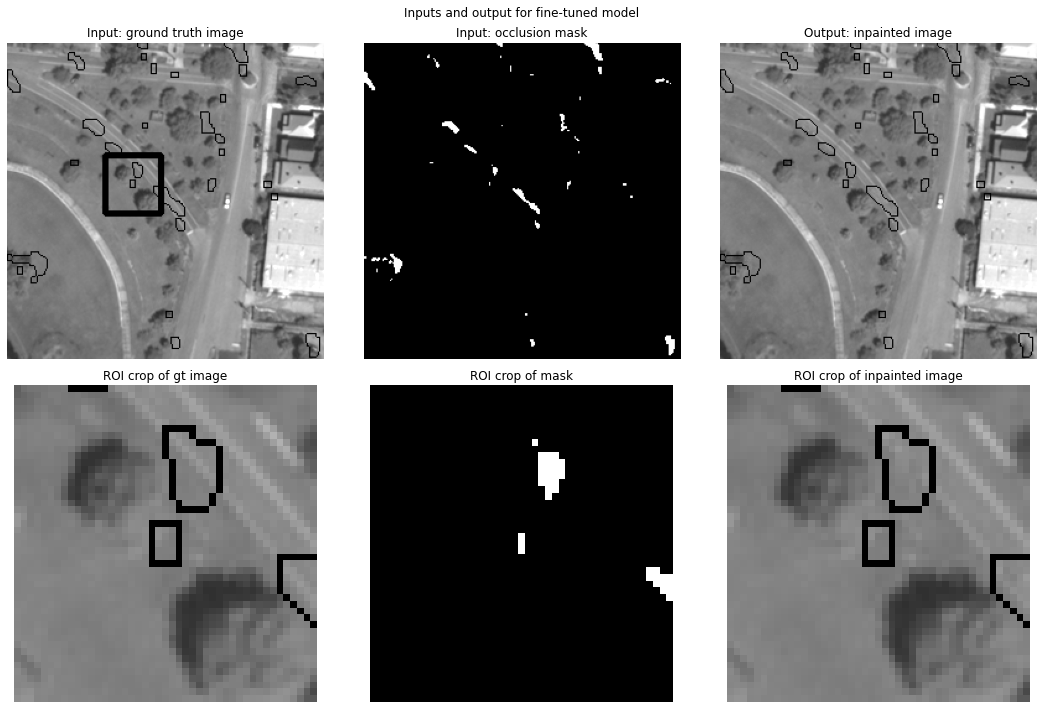

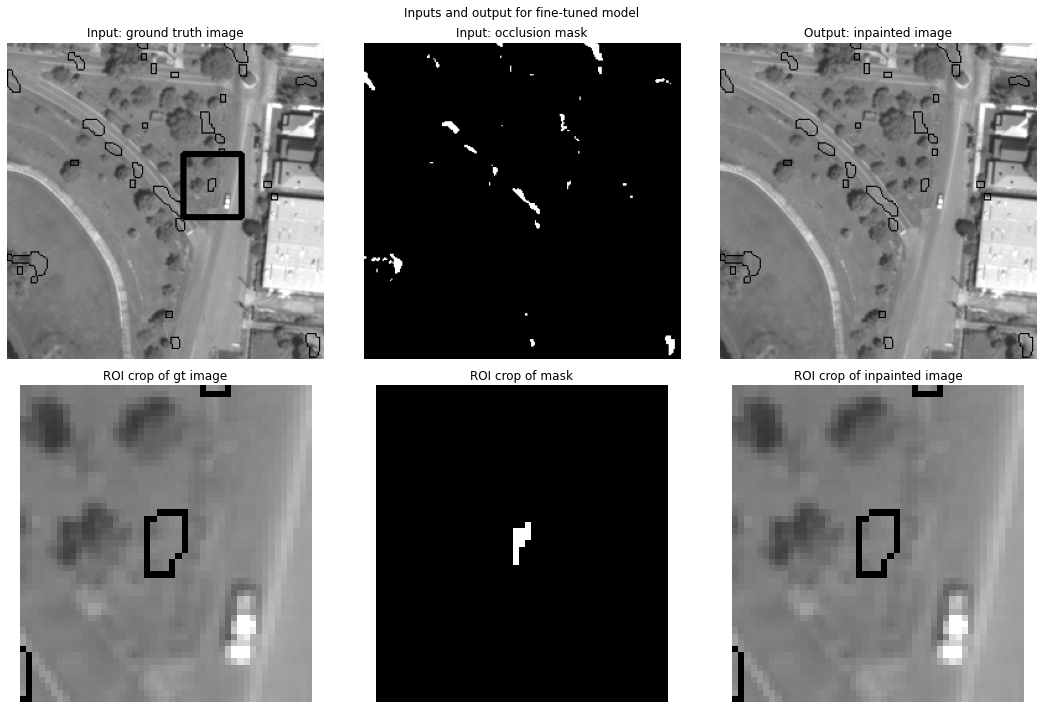

In [10]:
# find 1 areas in mask, use 3 pixels' dilation and draw the boundary on original image and output image
# image and predicted image are panchromatic grayscale images, nodata value is 2**16-1
for mask_name, img_name, output_name in zip(mask_names, img_names, output_names):
    result_num = 0
    # read image while ignoring nodata value
    image = cv2.imread(img_name, cv2.IMREAD_UNCHANGED)
    nodata_mask = image == 2**16-1
    image = image.astype(np.float32)
    image[nodata_mask] = np.nan
    mask_ = cv2.imread(mask_name, cv2.IMREAD_UNCHANGED)
    mask = (nodata_mask | mask_)*1
    output = cv2.imread(output_name, cv2.IMREAD_UNCHANGED)

    # use 3 pixels' dilation to find the boundary of 1 areas
    kernel = np.ones((5,5), np.uint16)
    mask_dilation = cv2.dilate(mask, kernel, iterations=1)

    # find the findContours of mask_dilation
    contours, _ = cv2.findContours(mask_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    for contour in contours:
        cv2.drawContours(image, contour, -1, (0, 0, 255), 1)
        cv2.drawContours(output, contour, -1, (0, 0, 255), 1)

    vmin = np.min(output)
    vmax = np.max(output)

    for i, contour in enumerate(contours):
        x, y, w, h = cv2.boundingRect(contour)
        
        # # 截取包含roi的大小为80*80的区域
        # roi_image = image[y-50:y+h+50, x-50:x+w+50]
        # roi_output = output[y-50:y+h+50, x-50:x+w+50]
        # roi_mask = mask[y-50:y+h+50, x-50:x+w+50]
        a = np.maximum(0, y-20)
        b = np.minimum(y+h+20, image.shape[0])
        c = np.maximum(0, x-20)
        d = np.minimum(x+w+20, image.shape[1])
        roi_image = image[a:b, c:d]
        roi_output = output[a:b, c:d]
        roi_mask = mask[a:b, c:d]

        # plot the image, mask, output in the first row, and the roi_image, roi_mask, roi_output in the second row
        fig, ax = plt.subplots(2, 3, figsize=(15, 10))
        # draw the bounding box of the roi on the image
        image_show= cv2.rectangle(image.copy(), (c, a), (d, b), (0, 255, 0), 4)
        fig.suptitle('Inputs and output for fine-tuned model') #  trained from scratch, original 
        ax[0, 0].imshow(image_show, cmap='gray', vmin=vmin, vmax=vmax)
        ax[0, 0].set_title('Input: ground truth image')
        ax[0, 0].axis('off')
        ax[0, 1].imshow(mask, cmap='gray')
        ax[0, 1].set_title('Input: occlusion mask')
        ax[0, 1].axis('off')
        ax[0, 2].imshow(output, cmap='gray', vmin=vmin, vmax=vmax)
        ax[0, 2].set_title('Output: inpainted image')
        ax[0, 2].axis('off')
        ax[1, 0].imshow(roi_image, cmap='gray', vmin=vmin, vmax=vmax)
        ax[1, 0].set_title('ROI crop of gt image')
        ax[1, 0].axis('off')
        ax[1, 1].imshow(roi_mask, cmap='gray')
        ax[1, 1].set_title('ROI crop of mask')
        ax[1, 1].axis('off')
        ax[1, 2].imshow(roi_output, cmap='gray', vmin=vmin, vmax=vmax)
        ax[1, 2].set_title('ROI crop of inpainted image')
        ax[1, 2].axis('off')
        plt.tight_layout()
        plt.show()
        plt.close()
        result_num += 1
        if result_num > 10:
            break
    break